Development code.

In [141]:
# Requirements: 
#  - sox + soundfile + our vowel_discri package
#  - ABXpy.distances (could be made independent from ABXpy)

import soundfile
import os
import os.path as path
import pandas as pd
import numpy as np
import seaborn
from ast import literal_eval as make_tuple
import wave
import subprocess
import shutil


# To get vowel_discri from github repo, run:
#   export PYTHONPATH=:/path/2/vowel-discri/repository:`$PYTHONPATH`
# in the terminal before launching jupyter notebook
import vowel_discri.mfcc as mfcc_lib

%matplotlib inline

### Load relevant data

In [69]:
# load raw data, this should be changed when we make the repository public
# so that the script can be used by anybody to reproduce our results (doing wget to download the files directly
# from the OSF server) 
root = '/Users/admin/Documents/PhD/Data/vowel_discri/osf'
wav_dir = path.join(root, 'Stimuli', 'final_stimuli')

xp_designs_path = path.join('/Users/admin/Documents/PhD/Data/vowel_discri', 'xp_designs.txt')

filename = {'ES': 'InPhonDb_native_nonnative - vowels.csv',
            'F1F2_natural': path.join('F1F2_measures', 'formants_natural.txt'),
            'F1F2_synthetic': path.join('F1F2_measures', 'formants_synthetic.txt'),
            'stim_groups': 'Stimulus name mapping - mapping.csv'}
sep = {'ES': ",", 'F1F2_natural': "\t",'F1F2_synthetic': "\t", 'stim_groups': ","}
data = {}
for key in filename:
    data[key] = pd.read_csv(path.join(root, filename[key]), sep=sep[key])

### Create XP designs

Set up a file describing the base and deviant stimuli used for each trial of each experiment
(one experiment==one effect size) to the best of our knowledge. Effect size identifier ("ES_id") are obtained from the "effect_ID" column of: https://docs.google.com/spreadsheets/d/1zOMMXqKL_wunKTqQ52hkdAFwM5PVhlUX3Vv_29UlIn4/edit#gid=1461185663.

For the natural stimuli, the xp_design file is assembled based on "Stimulus name mapping" google document set up by Sho (https://docs.google.com/spreadsheets/d/1Yplb66D3E9ow3n-LjEAxxNoyYiJlA0csm1yl05-2GFc/edit#gid=35503803). Habituation stimuli were not included when they were not used during test, provided we were able to identify them (as specified in the google sheet). There might be a need for some corrections. **In particular all stimuli were assumed to be presented at each trial, which might not be accurate.** Another thing might be inaccurate, although it does not matter for the current study since we do not look at asymetries and use only symmetric measures: counterbalancing of base/deviant role was assumed for all experiments. 
    
For the synthetic stimuli, this uses the stimuli names suggested by Sho in the "Stimulus name mapping" google document above, but with some corrections. In particular:
    - only test stimuli were included
    - counterbalancing and included stimuli were matched to the trial structure described in the original papers


In [44]:
def add_kuhl82_es1_design(xp_designs): 
    # Kuhl82 first effect size has a special trial structure
    es_id = 7
    study_id = 'Kuhl1982'
    bases = [('kuhl82_p1_a_monotone.wav',), ('kuhl82_p1_a_rise_fall.wav',)]
    deviants = [('kuhl82_p1_i_monotone.wav',), ('kuhl82_p1_i_rise_fall.wav',)]
    counterbalanced = True
    trial = 1
    for base, deviant in zip(bases, deviants):      
        xp_designs['study_id'].append(study_id)
        xp_designs['ES_id'].append(es_id)
        xp_designs['trial_id'].append(trial)
        xp_designs['base_stims'].append(base)
        xp_designs['deviant_stims'].append(deviant)
        trial = trial+1
        if counterbalanced:
            xp_designs['study_id'].append(study_id)
            xp_designs['ES_id'].append(es_id)
            xp_designs['trial_id'].append(trial)
            xp_designs['base_stims'].append(deviant)
            xp_designs['deviant_stims'].append(base)
            trial = trial+1
    return xp_designs

In [45]:
# collect effect size ids
pair2ESid = {}
pair2studyid = {}
for pair, df in data['ES'].groupby('stimulus_pair'):
    if not(pair.strip == ''):
        pair2ESid[pair] = list(df['effect_ID'])
        pair2studyid[pair] = list(df['study_ID'])

# get list of stimuli wavs
wavs = os.listdir(wav_dir) 
wavs = [wav for wav in wavs if wav[-4:] == '.wav']
# function to determine if a stim is base or deviant
# this is ad hoc, as stim could play different roles
# in different studies, but works here in combination
# with 'not_counterbalanced' below
is_base = {
    'liu16_p1': lambda name: '_i_' in name,
    'mazuka13_p1': lambda name: '_e_' in name,
    'mazuka13_p2': lambda name: '_u_' in name,
    'mazuka13_p3': lambda name: '_ue_' in name,
    'mugitani09_p1': lambda name: '_aa_' in name,
    'mugitani09_p2': lambda name: '_aa_' in name,
    'phan08_p1': lambda name: '_aimw_' in name,
    'phan08_p2': lambda name: '_ais_' in name,
    'phan08_p3': lambda name: '_aimw_' in name,
    'phan08_p4': lambda name: '_V_' in name,
    'polka96_p1': lambda name: '_u_' in name,
    'sebastian09_p1': lambda name: '_o_' in name,
    'sebastian09_p2': lambda name: '_e_' in name,
    'sundara11_p1': lambda name: '_eh_' in name,
    'tsuji17_p1': lambda name: '_ei_' in name,
    'tsuji17_p2': lambda name: '_oi_' in name,
    'tsuji17_p3': lambda name: '_a_' in name,
    'versteegh15_p1': lambda name: '_ei_' in name,
    'figueras10_p1': lambda name: '_o_' in name,
    'cardillo10_p1': lambda name: '_u' in name,
    'kuhl79_p1': lambda name: '_a_' in name,
    'kuhl82_p1': lambda name: '_a_' in name,
    'swoboda76_p1': lambda name: '_i_' in name,
    'tsao04_p1': lambda name: '_u' in name, 
    'marean92_p1': lambda name: '_a_' in name}
for i in range(1, 10):
    is_base['eilers84_p{}'.format(i)] = lambda name: '300' in name
for i in range(1, 5):
    is_base['trainor02_p{}'.format(i)] = lambda name: '_i_' in name

# list of effect size for which base/deviant role was counterbalanced
ll = ['tsao04_p1', 'cardillo10_p1', 'marean92_p1'] +\
     ['eilers84_p{}'.format(i) for i in range(1, 10)]
not_counterbalanced = [es_id for pair in ll for es_id in pair2ESid[pair]]

# instantiate xp_design structure, study_ID is included for human readability
cols = ['study_id', 'ES_id', 'trial_id', 'base_stims', 'deviant_stims']
xp_designs = {col : [] for col in cols}
for pair in pair2ESid:
    if pair == 'sebastian09_p2':
        # we ignore this one because we are not sure what the experimental stimuli were
        continue
    pair_wavs = [wav for wav in wavs if wav[:len(pair)] == pair]
    bases = tuple([wav for wav in pair_wavs if is_base[pair](wav)])
    deviants = tuple([wav for wav in pair_wavs if not(is_base[pair](wav))])
    for ES_id, study_id in zip(pair2ESid[pair], pair2studyid[pair]):
        if ES_id == 7:
            # Kuhl82 first effect size has a special trial structure
            assert pair == 'kuhl82_p1'
            xp_designs = add_kuhl82_es1_design(xp_designs)
        else:
            xp_designs['study_id'].append(study_id)
            xp_designs['ES_id'].append(ES_id)
            xp_designs['trial_id'].append(1)
            xp_designs['base_stims'].append(bases)
            xp_designs['deviant_stims'].append(deviants)
            if not(ES_id in not_counterbalanced):
                # counterbalance base/deviant role
                xp_designs['study_id'].append(study_id)
                xp_designs['ES_id'].append(ES_id)
                xp_designs['trial_id'].append(2)
                xp_designs['base_stims'].append(deviants)
                xp_designs['deviant_stims'].append(bases)
xp_designs = pd.DataFrame(xp_designs)
# make sure column order is nice
xp_designs = xp_designs[cols]
# make sure row order is nice
xp_designs = xp_designs.sort_values(["study_id", "ES_id"])
xp_designs.to_csv(xp_designs_path, sep=" ")


In [11]:
def read_xp_designs(xp_designs_path):
    xp_designs = pd.read_csv(xp_designs_path, sep=" ")
    del xp_designs['Unnamed: 0']
    xp_designs['base_stims'] = [make_tuple(e) for e in xp_designs['base_stims']]
    xp_designs['deviant_stims'] = [make_tuple(e) for e in xp_designs['deviant_stims']]
    return xp_designs

xp_designs = read_xp_designs(xp_designs_path)


### Standardize wavefiles

stereo -> mono and resampling to 16000 Hz (MFCC function takes fs as an argument, but I don't think it is using it to do the same thing independently of sampling rate).

In [152]:
std_wav_dir = path.join(root, 'Stimuli', 'standardized_final_stimuli')
standardize_fs = True  # If true resample all wavefiles to standard_fs Hz sampling rate
standard_fs = 16000

base_wavs = [f for e in xp_designs['base_stims'] for f in e]
deviant_wavs = [f for e in xp_designs['deviant_stims'] for f in e]
wavs = base_wavs + deviant_wavs

for wav in wavs:
    fpath = path.join(wav_dir, wav)
    std_fpath = path.join(std_wav_dir, wav)
    tmp_out = os.path.join(std_wav_dir, '__tmp__.wav')  # to avoid shennanigans with self-replacement of a file
    with wave.open(fpath, 'rb') as fh:
        params = fh.getparams()
        assert params.comptype == 'NONE', wav
        assert params.compname == 'not compressed', wav
        assert params.sampwidth == 2, wav  # 2 bytes == 16 bits
        try:
            assert params.nchannels == 1, wav
        except AssertionError:
            assert params.nchannels == 2
            # fuse channels with sox
            out = subprocess.run(["sox", fpath, tmp_out, "channels", "1"]) 
            assert out.returncode == 0, out
            shutil.move(tmp_out, std_fpath)
            fpath = std_fpath
        if standardize_fs and params.framerate != standard_fs:
            out = subprocess.run(["sox", fpath, "-r", str(standard_fs), tmp_out]) 
            assert out.returncode == 0, out
            shutil.move(tmp_out, std_fpath)
            fpath = std_fpath
        if fpath != std_fpath:
            shutil.copy(fpath, std_fpath)
if path.exists(tmp_out):
    os.remove(tmp_out)

### Get MFCC and F1F2 figure for each wavefile

**Some F1/F2 measurements are currently missing**

In [36]:
# Get MFCCs for each wav
mfcc = {}
for wav in wavs:
    fpath = os.path.join(std_wav_dir, wav)
    data, fs = soundfile.read(fpath)
    mfcc[wav] = mfcc_lib.mfcc(data, fs).T  # take the transpose to be in dtw.dtw expected format 

In [37]:
# Get F1F2 for each wav
def read_F1F2(filename, sep):
    f1f2_n = pd.read_csv(path.join(root, filename['F1F2_natural']), sep=sep['F1F2_natural'])
    f1f2_s = pd.read_csv(path.join(root, filename['F1F2_synthetic']), sep=sep['F1F2_synthetic'])
    f1f2_all = pd.concat([f1f2_n, f1f2_s])
    f1f2 = {}
    missing_f1f2 = []
    for wav in wavs:
        line = f1f2_all[f1f2_all['Filename'] == wav[:-4]]
        if len(line) == 0:
            missing_f1f2.append(wav)
        else:
            assert len(line) == 1
            f1f2[wav] = np.array([line.f1early.iloc[0], line.f2early.iloc[0],
                                  line.f1mid.iloc[0], line.f2mid.iloc[0],
                                  line.f1late.iloc[0], line.f2late.iloc[0]])
    return f1f2, missing_f1f2

f1f2, missing_f1f2 = read_F1F2(filename, sep)

### Define dissimilarity measures

In [39]:
import ABXpy.distances.metrics.dtw as dtw
# cosine in ABXpy is actually the angular distance
import ABXpy.distances.metrics.cosine as cos


def dtw_cosine(x, y):
    return dtw.dtw(x, y, cos.cosine_distance, normalized=True)


def rms_euclidean(x, y):
    d = np.sum((x[:2]-y[:2])**2) + \
        np.sum((x[2:4]-y[2:4])**2) + \
        np.sum((x[4:]-y[4:])**2)
    d = np.sqrt(d/3.)
    return d

### Simulate experiments
Get acoustics based ES predictors given xp_designs, distance function, features for each wav

In [132]:
def simulate_trial(df, dis, feats):
    assert len(df) == 1, df
    xs = df['base_stims'].iloc[0]
    ys = df['deviant_stims'].iloc[0]
    # assumes counterbalancing here, or at least ignore possible asymetries
    # there is probably a more df-style way of doing this, possibly by renaming
    # columns and doing an external merge
    D_across = 0
    for x in xs:
        for y in ys:
            D_across = D_across + dis(feats[x], feats[y])**2  
    D_within_x = 0
    for x1 in xs:
        for x2 in xs:
            D_within_x = D_within_x + dis(feats[x1], feats[x2])**2            
    D_within_y = 0
    for y1 in ys:
        for y2 in ys:
            D_within_y = D_within_y + dis(feats[y1], feats[y2])**2        
    m = len(xs)
    n = len(ys)    
    D_across = D_across / float(m*n)
    D_within = .5 * (D_within_x / float(m*m) +  D_within_y / float(n*n)) 
    D = np.sqrt(max(0, D_across-D_within)) 
    return pd.Series({'D': D}, index=['D'])


def simulate_xp(xp_design, dis, feats):
    by_trial = xp_design.groupby('trial_id').apply(lambda df: simulate_trial(df, dis, feats))
    by_trial.reset_index(level=by_trial.index.names, inplace=True)
    return by_trial.groupby('trial_id', as_index=False).mean()


def simulate_xps(xp_designs, dis, feats):
    res = xp_designs.groupby(['study_id', 'ES_id']).apply(lambda df: simulate_xp(df, dis, feats))
    res.reset_index(level=res.index.names, inplace=True)
    return res
 

mfcc_regs = simulate_xps(xp_designs, dtw_cosine, mfcc)


# provisory f1f2_regs (exclusions based on missing_f1f2)
excluded = ['Eilers1984', 'Marean1992', 'Mazuka2013', 'Phan2008', 'Swoboda1976', 'Trainor2002', 'Tsuji2017', 
            'Versteegh2015']
xp_designs2 = xp_designs[[not(e in excluded) for e in xp_designs['study_id']]]
f1f2_regs = simulate_xps(xp_designs2, rms_euclidean, f1f2)
mfcc_regs_restricted = simulate_xps(xp_designs2, dtw_cosine, mfcc)

/Users/admin/anaconda/lib/python3.5/site-packages/ABXpy-0.1.0-py3.5-macosx-10.5-x86_64.egg/ABXpy/distances/metrics/cosine.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  d = np.float64(scipy.arccos(d) / np.pi)


### Assemble results

Assemble dataframe with ES and all relevant predictors (including ones for F1F2 and mfcc).
Can then be shipped for mutilevel linear modeling and further analyses.

Use 'g_calc' column for effect sizes in inphondb gdoc from OSF is that correct?

**TODO**: add other relevant predictors:
    - L1
    - age
    - counterbalancing
    - experimental method
    - ... (what else do we have in prereg?)

In [137]:
df = pd.DataFrame({'ES_id': data['ES']['effect_ID'], 'ES': data['ES']['g_calc']})
res_df = pd.merge(mfcc_regs, df, on='ES_id')
res_df_f1f2 = pd.merge(f1f2_regs, df, on='ES_id')
res_df_mfcc_restricted = pd.merge(mfcc_regs_restricted, df, on='ES_id')
del res_df_mfcc_restricted['level_2']
del res_df_f1f2['level_2']

### Quick look at the results and exploratory analyses

[[1.         0.53031387]
 [0.53031387 1.        ]]


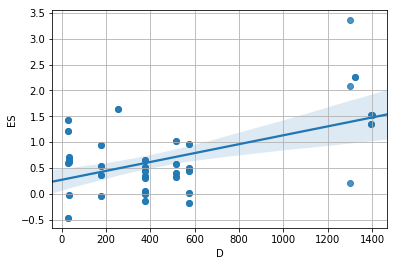

In [143]:
# F1F2
g = seaborn.regplot(data=res_df_f1f2, x='D', y='ES')
g.axes.grid()
arr = np.column_stack([res_df_f1f2['D'], res_df_f1f2['ES']]).T
print(np.corrcoef(arr))

[[1.         0.56925343]
 [0.56925343 1.        ]]


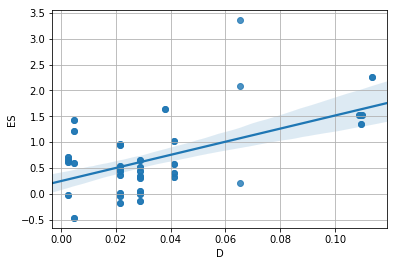

In [142]:
# MFCC (on same studies as available for F1F2)
g = seaborn.regplot(data=res_df_mfcc_restricted, x='D', y='ES')
g.axes.grid()
arr = np.column_stack([res_df_mfcc_restricted['D'], res_df_mfcc_restricted['ES']]).T
print(np.corrcoef(arr))

[[1.         0.93235009]
 [0.93235009 1.        ]]


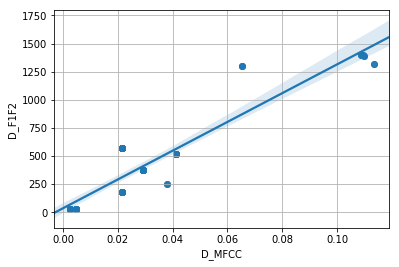

In [161]:
# Correlation MFCC vs F1F2 predictions
data_both = pd.merge(res_df_mfcc_restricted, res_df_f1f2, on=['study_id', 'ES_id', 'trial_id', 'ES'],
                     suffixes=['_MFCC', '_F1F2'])
assert len(data_both) == len(res_df_mfcc_restricted)
assert len(data_both) == len(res_df_f1f2)
g = seaborn.regplot(data=data_both, x='D_MFCC', y='D_F1F2')
g.axes.grid()
arr = np.column_stack([data_both['D_MFCC'], data_both['D_F1F2']]).T
print(np.corrcoef(arr))

[[1.         0.49447673]
 [0.49447673 1.        ]]


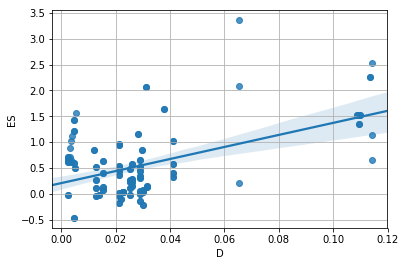

In [144]:
# MFCC on all studies, but that include some pure duration contrasts we don't want to look at.
g = seaborn.regplot(data=res_df, x='D', y='ES')
g.axes.grid()
arr = np.column_stack([res_df['D'], res_df['ES']]).T
print(np.corrcoef(arr))
study_id ES_id level_2 trial_id

[[1.         0.61153935]
 [0.61153935 1.        ]]


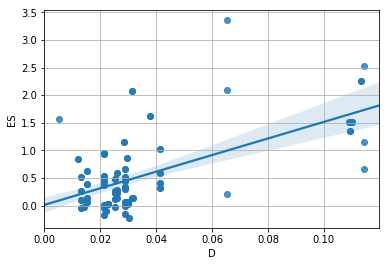

In [150]:
# MFCC on all studies but the ones with duration contrasts (not completely sure the filtering is perfect here...)
g = seaborn.regplot(data=res_df[(res_df['D']>=.005)], x='D', y='ES')
g.axes.grid()
arr = np.column_stack([res_df[res_df['D']>.005]['D'], res_df[res_df['D']>.005]['ES']]).T
print(np.corrcoef(arr))

[[1.         0.17180561]
 [0.17180561 1.        ]]


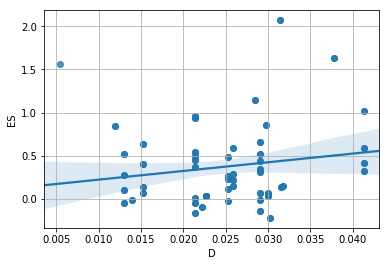

In [151]:
# MFCC without duration contrasts and without the studies with the largest differences
g = seaborn.regplot(data=res_df[(res_df['D']<=.06) & (res_df['D']>=.005)], x='D', y='ES')
g.axes.grid()
arr = np.column_stack([res_df[(res_df['D']<=.06) & (res_df['D']>=.005)]['D'], res_df[(res_df['D']<=.06) & (res_df['D']>=.005)]['ES']]).T
print(np.corrcoef(arr))

**TODO**
Exploratory analyses (did we pre-reg. some of them?)
  - analysis restricted to most reliable stimuli subset (e.g. accurate resynthesis and/or detailed knowledge of xp design)?
  - restricted to counterbalanced studies to avoid asymmetry effects?
    
   
Notes on input features (independent of this project):
    I don't understand the results with energy en within. Possible interpretation:
        en within at least DTW synchronization based on first MFCC/energy and computing distance on the rest is very good?
        -> test replacing first coefficient by energy scaled to be similar to first coefficient
        -> if works well, maybe try rescaling first coefficient to be more like others and using very salient energy to see if first coefficient might bring something useful on top of energy? More generally, change the distance function to be doing a DTW alignment on selected dimension(s), then get average distance along alignment path (does it make sense now to take the average?) on some other specified dimension(s) (possibly overlapping).
        -> comparing using only first MFCC to only energy to only rest of MFCC
        
    -> if all this true
        - does it generalize across speakers?
        - might suggest replacing DTW by some rhythmic/syllabic etc. alignment

In [165]:
with open(path.join(root, 'missing_f1f2.txt'), 'w') as fh:
    fh.write(str(missing_f1f2))